# Functions

In [1]:
gene_name="amacGFP"

Import modules
Define functions
Load amacGFP data
amacGFP 239 aa


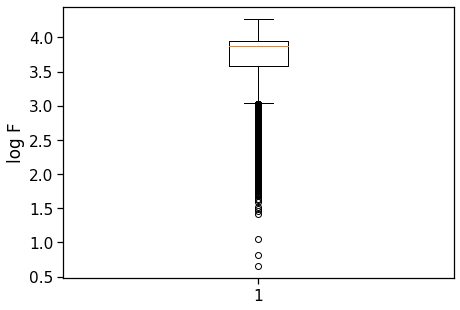

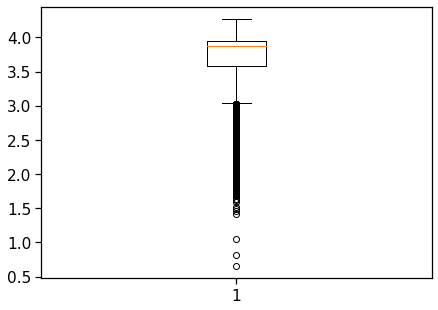

Pre-processing amacGFP
Load amacGFP encodings
Split train, valid, test sets
train_index 19803
valid_index 6601
test_index 6602


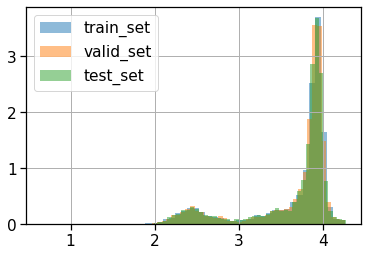

In [2]:
showmatrix=False
%run 01_preprocessing.ipynb
import itertools
import time
import seaborn as sns
from collections import Counter
from log_progress import log_progress

In [3]:
plot_range=(2,5)

In [4]:
def splitDataFrameIntoSmaller(df, chunkSize = 10000): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

def seq_to_genotype(seq):
    genotype=[]
    for i in range(len(seq)):
        if seq[i]!=wt_seq[i]:
            genotype.append(wt_seq[i]+str(i)+seq[i]) # Be very careful here

    if len(genotype)==0:
        return("wt")
    else:
        genotype=":".join(genotype)
        return(genotype)

# Load model and constants

In [5]:
df_thresh=pd.read_csv(join(modelsPath,f"{gene_name}_df_thresh.csv"),index_col=0) 

In [6]:
df_thresh_muts = sorted(list(flatten([ elt.split(":") for elt in df_thresh[genotype_col].values.flatten()])))


In [7]:
predictors_thresh=predictors.loc[df_thresh.index,:]
target_thresh=target.loc[df_thresh.index,:]

In [8]:
# load optimised model
model_file = join(modelsPath,f"{gene_name}_N1_N2_1_NN_optimized_filtered_training.h5")

optimised_model_filtered_training = keras.models.load_model(model_file)  
optimised_model_filtered_training.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4780)]            0         
_________________________________________________________________
dense (Dense)                (None, 20)                95620     
_________________________________________________________________
D1 (Dropout)                 (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               4200      
_________________________________________________________________
D2 (Dropout)                 (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 100,021
Trainable params: 100,021
Non-trainable params: 0
________________________________________________

# Predict genotypes manually

The following code can be used to predict genotypes manually

## Any genotype

In [9]:
pop=None
if gene_name=="amacGFP":
    
    genotypes_to_predict_pseudo = ["G22C"] # amacGFP example
    genotypes_to_predict_native = [pseudo_genotype_to_native(genotype) \
                                   for genotype in genotypes_to_predict_pseudo]

    # check that the converted genotypes are indeed native
    all_muts = sorted(list(set(flatten([elt.split(":") for elt in df[genotype_col].values.flatten()]))))
    for genotype in genotypes_to_predict_native:
        if set([mut in all_muts for mut in genotype.split(":") ])=={True}:
            print("OK")
        else:
            print("not OK")

    # encode
    pop = pd.DataFrame(genotypes_to_predict_native,columns=["aa_genotype_native"])
    pop["full_seq"] = get_seq_from_genotype.fit_transform(pop)
    predictors_tmp = one_hot_encoder(pop)
    predictors_tmp=predictors_tmp[[col for col in predictors_tmp.columns if "*" not in col]]

    # predict 
    fitnesses=pd.DataFrame(np.concatenate([optimised_model_filtered_training.predict(predictors_tmp.values) for i in range(20)],axis=1),index=predictors_tmp.index)
    fitnesses = fitnesses.add_prefix('Fitness_')
    pop["Fitness"] = fitnesses.median(axis=1)

pop

OK


,aa_genotype_native,full_seq,Fitness
0,G19C,MSKGEELFTGIVPVLIELDCDVHGHKFSVRGEGEGDADYGKLEIKF...,3.874381


## Intermediate mutants

In [10]:
pop=None
if gene_name=="cgreGFP":
    
    # predict mutants halfway between cgreGFP's wild-type and some defined mutant
    
    genotypes_to_predict_pseudo = ["A2T:T4P:E11D:E34V:I100T:N119D:I155V:M164L:M175L:A193V:E195V:L203P"]
    genotypes_to_predict_native = [pseudo_genotype_to_native(genotype) for genotype in genotypes_to_predict_pseudo]

    for genotype in genotypes_to_predict_native:

        # get all mutants 6 mutations away based on this genotype
        genotype=genotype.split(":")
        genotypes_6_muts = list(itertools.combinations(genotype, 6))

        # sort genotypes
        genotypes_6_muts = [sorted(genotype, key=lambda mut: int(mut[1:-1])) for genotype in genotypes_6_muts]
        genotypes_6_muts = [":".join(genotype) for genotype in genotypes_6_muts]

        # encode
        pop = pd.DataFrame(genotypes_6_muts,columns=["aa_genotype_native"])
        pop["full_seq"] = get_seq_from_genotype.fit_transform(pop)
        predictors_tmp = one_hot_encoder(pop)
        predictors_tmp=predictors_tmp[[col for col in predictors_tmp.columns if "*" not in col]]

        # predict 
        fitnesses=pd.DataFrame(np.concatenate([optimised_model_filtered_training.predict(predictors_tmp.values) for i in range(20)],axis=1),index=predictors_tmp.index)
        fitnesses = fitnesses.add_prefix('Fitness_')
        pop["Fitness"] = fitnesses.median(axis=1)

        pop["sampled_from"]=":".join(genotype)
        pop["gene"]=gene_name

    pop.to_csv("midpoint_genotypes.csv")
pop

## cheGFP2

In [11]:
# cheGFP2_seq is rather close to and has the same length as cgreGFP

In [12]:
pop=None
if gene_name=="cgreGFP":
    
    cheGFP2_seq = (("STALTEGGKLFEKEIPYITELEGDVEGMKFTIKGEGTGDGTTGLIKSKYICTTGDLPVPWATILSS"
                    "ISYGVFCFAKYPRHIADFFKSTQPDGYSQDRIISFDDDGQYDVKAKITYEDGTLYNRVVLDGTGFK"
                    "SNGNILGMRVLYHSPPHIIYILPDRKNGGMKIEYNKAFDVMGGGHQMTRHAQFNKPLGAWEEDYPM"
                    "YHHLSVWTSFGKDPEDDETDHLTIVEVIKAIDLDTYK*"))

    # encode
    pop = pd.DataFrame(["cheGFP2"],columns=["aa_genotype_native"])
    pop["full_seq"] = cheGFP2_seq
    predictors_tmp = one_hot_encoder(pop)
    predictors_tmp=predictors_tmp[[col for col in predictors_tmp.columns if "*" not in col]]

    # predict 
    fitnesses=pd.DataFrame(np.concatenate([optimised_model_filtered_training.predict(predictors_tmp.values)\
                                           for i in range(20)],axis=1),index=predictors_tmp.index)
    fitnesses = fitnesses.add_prefix('Fitness_')
    pop["Fitness"] = fitnesses.median(axis=1)

pop

# Genetic algorithm

## Parameters

In [13]:
nb_mutation_target=12


target number of mutations to aim at <br>
did : 6 12 18 24 30 36 42 48 60 72 78 84

In [14]:
non_extant_enrich=True

If True, we try to enrich predictions with mutations not observed in natural sequences

In [15]:
oscillate=False

up to nb_mutation_target=48 included, genotypes were selected based only on their fitness level<br>
beyond that threshold, it became very difficult to find genotypes brighter or equivalent to wt<br>
so we tried instead to alternate between selecting genotypes with high numbers of mutations or high fitness,<br>
the choice between these behaviours being made randomly at each generation<br>
oscillate = False will select the genotypes based on their fitness only<br>
oscillate = True will alternate between the two selection methods<br>
(the ratio between the two behaviours can be set lower)<br>
Remark : it turneded out that predictions obtained when alternating are not funtional<br>
so oscillate =True is NOT recommended, instead, just run the algo with oscillate=False many times<br>



In [16]:
mut_proba=0.01

probability of adding a mutation while iterating along sequences

In [17]:
pop_size=50

size of the population to evolve

In [18]:
verbose=False

print info during run

In [19]:
record=False

whether to save the results of the run or not

In [20]:

if nb_mutation_target==6:
    
    generations=35
    
    if non_extant_enrich:
        if gene_name == "amacGFP":counter_selection = 50
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection = 20
        elif gene_name=="ppluGFP":counter_selection = 10
        else:raise
    else:        
        if gene_name == "amacGFP":counter_selection = 70
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection,mut_proba = 15, 0.05
        elif gene_name=="ppluGFP":counter_selection = 15
        else:raise


note: counter_selection is the ratio: reverting mutations / transforming mutations. <br>
The higher it is, the more reversions to wt sequence there are to choose from<br>
Using counter-selection is not entirely the same as having a low mutation probability <br>
counter selection allows reverting from evolutionary dead-ends<br>

In [21]:
if nb_mutation_target==12:

    generations=45
    
    if non_extant_enrich:
        if gene_name == "amacGFP":counter_selection = 10
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection = 10
        elif gene_name=="ppluGFP":counter_selection = 4
        else:raise
    else:
        if gene_name == "amacGFP":counter_selection = 20
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection = 15
        elif gene_name=="ppluGFP":counter_selection = 8
        else:raise


In [22]:
        
if nb_mutation_target==18:
    generations=45
    
    if non_extant_enrich:
        if gene_name == "amacGFP":counter_selection = 5
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":generations, counter_selection=60, 5
        elif gene_name=="ppluGFP":counter_selection = 5
        else:raise
    else:
        if gene_name == "amacGFP":counter_selection = 10
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection = 3
        elif gene_name=="ppluGFP":counter_selection = 5
        else:raise


In [23]:
        
if nb_mutation_target==24:
    generations=45
    
    if non_extant_enrich:
        if gene_name == "amacGFP":counter_selection = 2
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection = 1
        elif gene_name=="ppluGFP":counter_selection = 3
        else:raise
    else:
        if gene_name == "amacGFP":counter_selection = 5
        elif gene_name == "avGFP":counter_selection = 20
        elif gene_name=="cgreGFP":counter_selection = 1
        elif gene_name=="ppluGFP":counter_selection = 2
        else:raise


In [24]:
if nb_mutation_target==30:
    generations=50
    
    if non_extant_enrich:
        if gene_name=="ppluGFP":counter_selection, mut_proba=1,0.011
        elif gene_name=="cgreGFP":generations=60 
            
    else:
        if gene_name   == "amacGFP":counter_selection = 1
        elif gene_name == "ppluGFP":counter_selection = 1
        elif gene_name == "cgreGFP":counter_selection = 1
        else:raise


In [25]:

if nb_mutation_target==36:
    generations=60
    
    if non_extant_enrich:
        if gene_name=="ppluGFP":counter_selection,mut_proba = 1, 0.014
        elif gene_name=="cgreGFP":generations,mut_proba=70, 0.014
        else:raise
    else:
        if gene_name == "ppluGFP":  counter_selection,mut_proba = 1, 0.012
        elif gene_name == "cgreGFP":counter_selection,mut_proba = 1, 0.012
        else:raise


In [26]:
if nb_mutation_target==42:
    generations=80
    
    if non_extant_enrich:
        if gene_name == "ppluGFP": counter_selection, mut_proba, generations=1, 0.013, 90
        elif gene_name == "cgreGFP": mut_proba, counter_selection = 0.0155, 1
        else:raise
            
    else:
        if gene_name == "ppluGFP": counter_selection,mut_proba=1,0.014            
        elif gene_name == "cgreGFP": counter_selection,mut_proba=1,0.014            
        else:raise


In [27]:

if nb_mutation_target==48:
    generations=100
    
    if non_extant_enrich:
        if gene_name == "ppluGFP": counter_selection, mut_proba, generations=0.013,1,90
        elif gene_name == "cgreGFP": counter_selection,mut_proba,generations=1,0.0175,110
        else:raise
            
    else:
        if gene_name == "ppluGFP": counter_selection,mut_proba=1,0.014
        elif gene_name == "cgreGFP": generations,counter_selection,mut_proba=120,1,0.014
        else:raise


In [28]:

if nb_mutation_target==50:
    generations=150
    mut_proba=0.012
    
    if non_extant_enrich:
        if gene_name == "amacGFP": counter_selection = 2
        elif gene_name == "avGFP": counter_selection = 20
        elif gene_name=="cgreGFP": counter_selection = 1 
        elif gene_name=="ppluGFP": counter_selection = 3
        else:raise
    else:
        if gene_name == "amacGFP": counter_selection,mut_proba=1,0.013
        elif gene_name == "avGFP": counter_selection = 20
        elif gene_name=="cgreGFP": counter_selection = 1
        elif gene_name=="ppluGFP": counter_selection,mut_proba=1,0.01
        else:raise


In [29]:
           
if nb_mutation_target==54:
    generations=100
    oscillate=True
    oscillator_thresh=0.5
    
    if non_extant_enrich:
        if gene_name == "cgreGFP": counter_selection,mut_proba,generations = 1,0.013,75
        else:raise
            
    else:
        if gene_name == "cgreGFP": generations,counter_selection,mut_proba=75,1,0.012
        else:raise


In [30]:
           
if nb_mutation_target==60:
    generations=100
    oscillate=True
    oscillator_thresh=0.5
    
    if non_extant_enrich:
        if gene_name == "cgreGFP": counter_selection,mut_proba,generations=1,0.013,100            
        else:raise
            
    else:
        if gene_name == "cgreGFP": generations,counter_selection,mut_proba=250,1,0.012
        else:raise


In [31]:
           
if nb_mutation_target==66:
    generations=100
    oscillate=True
    oscillator_thresh=0.3
    
    if non_extant_enrich:
        if gene_name == "cgreGFP":counter_selection,mut_proba,generations=1,0.013,150
        else:raise
            
    else:
        if gene_name == "cgreGFP":generations,counter_selection,mut_proba=100,1,0.012
        else:raise


In [32]:
           
if nb_mutation_target==72:
    generations=100
    oscillate=True
    oscillator_thresh=0.5
    
    if non_extant_enrich:
        if gene_name == "cgreGFP":counter_selection,mut_proba,generations=1,0.013,150
        else:raise
            
    else:
        if gene_name == "cgreGFP":generations,counter_selection,mut_proba=100,1,0.012
        else:raise


In [33]:
           
if nb_mutation_target==78:
    oscillate=True
    oscillator_thresh=0.5
    
    if non_extant_enrich:
        if gene_name == "cgreGFP": counter_selection,mut_proba,generations = 1,0.013,150
        else:raise
            
    else:
        if gene_name == "cgreGFP": generations,counter_selection,mut_proba = 1,150,0.012
        else:raise


In [34]:
           
if nb_mutation_target==84:
    oscillate=True
    oscillator_thresh=0.5
    
    if non_extant_enrich:
        
        if gene_name == "cgreGFP":counter_selection,mut_proba,generations=1,0.013,180
        else:raise
            
    else:
        if gene_name == "cgreGFP": generations,counter_selection,mut_proba=150,1,0.012
        else:raise


In [35]:
           
if nb_mutation_target==90:
    oscillate=True
    oscillator_thresh=0.8
    
    if non_extant_enrich:        
        if gene_name == "cgreGFP":counter_selection,mut_proba,generations = 1,0.011,130
        else:raise
            
    else:
        if gene_name == "cgreGFP": generations,counter_selection,mut_proba=200,1,0.012
        else:raise


In [36]:
           
if nb_mutation_target==96:
    oscillate=True
    oscillator_thresh=0.8
    
    if non_extant_enrich:        
        if gene_name == "cgreGFP":counter_selection,mut_proba,generations = 1,0.011,130
        else:raise
            
    else:
        if gene_name == "cgreGFP":generations,counter_selection,mut_proba=200,1,0.012
        else:raise


## Run

### prepare mutation set

In [37]:
nb_mutation_target

12

In [38]:
# get extant and non-extant mutations

# to list extant/non-extant mutations,
# use 03c_list_non_extant_mutations.ipynb
# not running the notebook here
# because it uses variable gene_name whose value would change

with open(join(cachedDataPath,"nonextant_muts_all_genes.pkl"),"rb") as infile:
    nonextant_mutations=pickle.load(infile)
    nonextant_mutations=nonextant_mutations[gene_name]
    
with open(join(cachedDataPath,"extant_muts_all_genes.pkl"),"rb") as infile:
    extant_mutations=pickle.load(infile)
    extant_mutations=extant_mutations[gene_name]
    
len(nonextant_mutations)

916

In [39]:
# if true, enrich in non-natural mutations

if non_extant_enrich:
    print(len(nonextant_mutations))
    muts_to_work_with = sorted(list(set([mut for mut in nonextant_mutations if mut in df_thresh_muts])))
    print(len(muts_to_work_with))
    # number of mutations from df_thresh_muts/nonextant_mutations 
    # use small (0<ratio<1) increasing value to gradually relax the constraint on non extant mutations
    
    ratio = 0.4 #default 
    
    if gene_name=="ppluGFP" and nb_mutation_target==30:
        ratio=0.5 
    if gene_name=="ppluGFP" and nb_mutation_target==36:
        ratio=0.6
    if gene_name=="cgreGFP" and nb_mutation_target>48:
        ratio=0.6
        
    muts_to_work_with = muts_to_work_with+[random.choice(df_thresh_muts) \
                                           for i in range(int(len(muts_to_work_with)*ratio))]
    
else:
    muts_to_work_with = sorted(list(set(df_thresh_muts)))

print(len(muts_to_work_with),"muts_to_work_with")



916
546
764 muts_to_work_with


In [40]:
# list deleterious, beneficial, neutral and uncertain (not enough contexts) mutations

infile=join(cachedDataPath,f"all_mutations_in_all_backgrounds_dict_with_avGFP_native.pkl")
mutations_in_all_backgrounds = pickle.load(open(infile, "rb" ))
mutations=mutations_in_all_backgrounds[gene_name]

deleterious_muts=[]
neutral_muts=[]
beneficial_muts=[]
uncertain_muts=[]

for mutation, in_all_backgrounds in mutations.items():
    
    fitness_impacts = in_all_backgrounds['with_mut'] - in_all_backgrounds['background']

    if len(fitness_impacts)>=5:
        fitness_impact=fitness_impacts.median()
        
        if fitness_impact>0.1:
            beneficial_muts.append(mutation)
        elif fitness_impact<-0.1:
            deleterious_muts.append(mutation)
        else:
            neutral_muts.append(mutation)
    else:
        uncertain_muts.append(mutation)


In [41]:
# exclude mutations that are not seen in enough backgrounds, so we can't realy assess their impact
muts_to_work_with = [mut for mut in muts_to_work_with if mut not in uncertain_muts]
print(len(muts_to_work_with))

743


In [42]:
# exclude severely deleterious mutations
# in particular when trying to add a lot of mutations

if (nb_mutation_target>=12 and gene_name in ["cgreGFP"]) or \
   (nb_mutation_target>=30 and gene_name in ["ppluGFP"]) or \
   (nb_mutation_target>=30 and gene_name in ["amacGFP"]):
    
    
    muts_to_work_with = [mut for mut in muts_to_work_with if mut not in deleterious_muts]
    
print(len(muts_to_work_with))

743


In [43]:
# removing stop codons although there should be none, since they are removed during preprocessing
muts_to_work_with=[mut for mut in muts_to_work_with if "*" not in mut]
print(len(muts_to_work_with))

743


In [44]:
# removing "wt"
muts_to_work_with = [elt for elt in muts_to_work_with if elt!="wt"]
print(len(muts_to_work_with))

743


In [45]:
# adding reverting mutations that restore mutated positions to the previous state
wt_genotype=[f"{wt_seq[i]}{i}{wt_seq[i]}" for i in range(len(wt_seq)) if i!=0]
muts_to_work_with+= wt_genotype*(1+int(len(muts_to_work_with)/len(wt_genotype)))*counter_selection
print(len(muts_to_work_with))

10263


### generations

In [46]:
# Initialise population with WT genotypes
random_pop = pd.DataFrame([wt_seq]*pop_size,columns=["full_seq"])
random_pop[genotype_col]="wt"

# to save genotypes that have the right number of mutations not just in the final generation
along_the_way_genotypes=[]

# Initialise variables
fitnesses_log = []
previous = 0
no_improvement = 0
genetic_log={}

oscillator=1
# -------------------------------- generation loop --------------------------------
for g in log_progress(range(generations), every=None, size=None, name='Generations'):
    
    if verbose: print("g"+str(g))

    # build/update full_seq based on genotype (and wt seq)
    random_pop["full_seq"] = get_seq_from_genotype.fit_transform(random_pop)
    
    # encode as one-hot
    predictors_g = get_one_hot_encoding_pl.fit_transform(random_pop)
    cols = [col for col in predictors_g.columns if "*" not in col]
    predictors_g = predictors_g.loc[:,cols]
    
    fitnesses=pd.DataFrame(np.concatenate([optimised_model_filtered_training.predict(predictors_g.values) for i in range(20)],axis=1),index=predictors_g.index)
    fitnesses = fitnesses.add_prefix('Fitness_')
    random_pop["Fitness"] = fitnesses.median(axis=1)
    random_pop["Std"] = fitnesses.std(axis=1)
    
    # sort by fitness in prevision of rank selection
    random_pop["distance"]=random_pop[genotype_col].apply(lambda x:len(x.split(":")))
    
    random_pop = random_pop.sort_values(by=["Fitness","distance"],ascending=False)
    if oscillate:
        if random.uniform(0,1)<oscillator_thresh:
            random_pop = random_pop.sort_values(by=["distance","Fitness"],ascending=False)
    
    along_the_way_genotypes.append(random_pop[random_pop[genotype_col].apply(lambda x:len(x.split(":")))==nb_mutation_target])
    
    # print top sequence for info
    if verbose: print(random_pop.iloc[0,:]["full_seq"])
    
    # Save population with all the info
    genetic_log[g] = random_pop
    
    # on the go metrics
    fitnesses_log.append(list(random_pop["Fitness"].values))
    improvement = random_pop["Fitness"].max()-previous
    previous = random_pop["Fitness"].max()
    
    # if the desired number of generations is reached, we don't modify genotypes anymore
    
    if g<generations-1:
        
        # exclude genotypes that have the right nb of muts to leave space for the others
        random_pop=random_pop[random_pop.distance<nb_mutation_target] 
        
        # Rank selection on fitness value, and keep only the genotype+sequence
        random_pop=random_pop.iloc[:pop_size,:2]

        # Crossing-over with probability of 70%
        fittest_with_fittest = False # if True the fittest genotypes will cross together
        cross_proba = 0.7
        if not fittest_with_fittest:
            random_pop = shuffle(random_pop)
        
        couples = splitDataFrameIntoSmaller(random_pop, chunkSize = 2)
        for c in range(len(couples)):
            couple = couples[c]
            # if there are 2 sequences in the couple, perform crossing overs
            if len(couple)==2:
                if random.random()<cross_proba:
                    CO_number = random.choice(range(5))
                    CO_positions = sorted([random.choice(range(len(couple.iloc[0]["full_seq"]))) for i in range(CO_number)])
                    for CO_pos in CO_positions:

                        old_seq0 = couple.iloc[0]["full_seq"]
                        old_seq1 = couple.iloc[1]["full_seq"]

                        new_seq0 = old_seq0[:CO_pos]+old_seq1[CO_pos:]
                        new_seq1 = old_seq1[:CO_pos]+old_seq0[CO_pos:]

                        couple.iloc[0]["full_seq"] = new_seq0
                        couple.iloc[1]["full_seq"] = new_seq1

                        # re-compute genotypes after CO
                        couple.iloc[0][genotype_col] = seq_to_genotype(couple.iloc[0]["full_seq"])
                        couple.iloc[1][genotype_col] = seq_to_genotype(couple.iloc[1]["full_seq"])


            # Mutation
            for ID,row in couple.iterrows(): #0, 1 
                for c in range(len(couple.loc[ID]["full_seq"])): # go through sequence of parent
                    if random.random()<mut_proba:
                        # do mutation
                        mut = random.choice(muts_to_work_with)
                        # modify genotype
                        genotype = couple.loc[ID][genotype_col].split(":")
                        if genotype==["wt"]:
                            genotype=[]

                        # remove mutations previously affecting this position
                        genotype=[elt for elt in genotype if not elt[1:-1]==mut[1:-1]]

                        # if the genotype already has the desired length, remove one mutation randomly
                        if len(genotype)>nb_mutation_target:
                            genotype = shuffle(genotype)[:-1]

                        # if the mutation is a transforming mutation, just add it to the genotype
                        if mut[0]!=mut[-1]:
                            genotype.append(mut)

                        # finally, sort and join genotype again
                        genotype = [(elt[0],int(elt[1:-1]),elt[-1]) for elt in genotype]
                        genotype.sort(key=lambda x: x[1])

                        if len(genotype)==0:
                            genotype="wt"
                        else:
                            genotype = ":".join(["".join([str(e) for e in elt]) for elt in genotype])

                        couple.loc[ID][genotype_col]=genotype
                        # full_seq will be updated using genotype at the beginning of the loop


        # make a df from the result of couples and concat to the rest of the population
        couples = pd.concat(couples,axis=0)
        random_pop=pd.concat([random_pop,couples],axis=0,ignore_index=True)
    

In [47]:
# the genotypes found in previous generations that have the target number of genes
# to the final population
along_the_way_genotypes=pd.concat(along_the_way_genotypes)

In [48]:
# merge with random_pop
random_pop=pd.concat([random_pop,along_the_way_genotypes])

## Results

In [49]:
len(np.unique(random_pop[genotype_col]))

42

### Fitness distr. vs generations


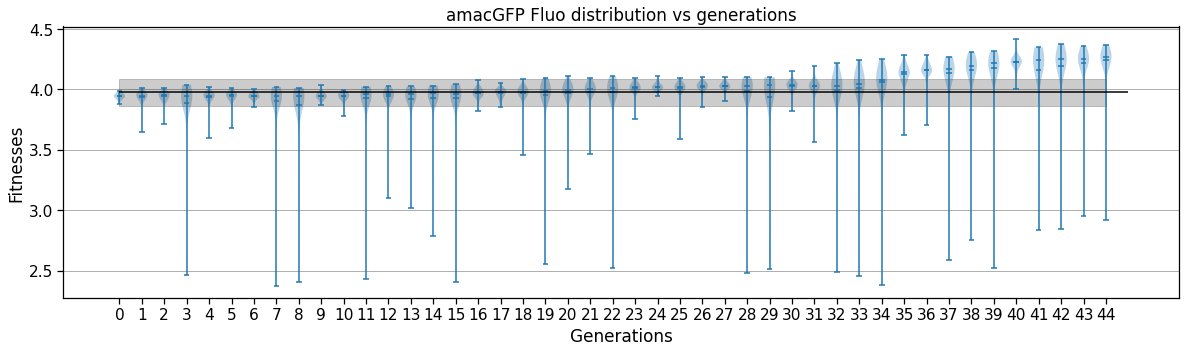

In [50]:
def chunks(lst, n):
    bits=[]
    for i in range(0, len(lst), n):
        bits.append(lst[i:i + n])
    return(bits) 

# plot the distribution of fitnesses at each generation

violins_per_line = generations
nb_subfigs =int(len(fitnesses_log)/violins_per_line)
fig, ax = plt.subplots(nb_subfigs,
                       1,
                       figsize=(20, 5*nb_subfigs))
if nb_subfigs==1:
    ax=[ax]
fig.patch.set_facecolor('w')


subsets = chunks(fitnesses_log,violins_per_line)
ticks = chunks(range(len(fitnesses_log)),violins_per_line)

for i in range(len(subsets)) :
    
    ax[i].violinplot(dataset=subsets[i],
                     positions=ticks[i],
                     showmeans=True,
                     showmedians=True)
    
    ax[i].yaxis.grid(True)
    ax[i].set_xlabel('Generations')
    ax[i].set_ylabel("Fitnesses")
    
    ax[i].set_xticks(ticks[i])
    ax[i].set_axisbelow(True)

# get wt fluorescence
wt_fluo = float(wt_record[brightness_col])
plt.hlines(y=wt_fluo,xmin=0,xmax=generations, colors='k')

# get wt uncertainty
try:
    wt_Std=float(genetic_log[0][genetic_log[0][genotype_col]=="wt"].head(1)["Std"])
except:
    wt_Std=0
    
plt.fill_between(x=range(generations),
                 y1=[wt_fluo+wt_Std for i in range(generations)],
                 y2=[wt_fluo-wt_Std for i in range(generations)],
                 color="k",
                 alpha=0.2)

plt.title(gene_name+" Fluo distribution vs generations")
plt.show()

### Mutations vs generations

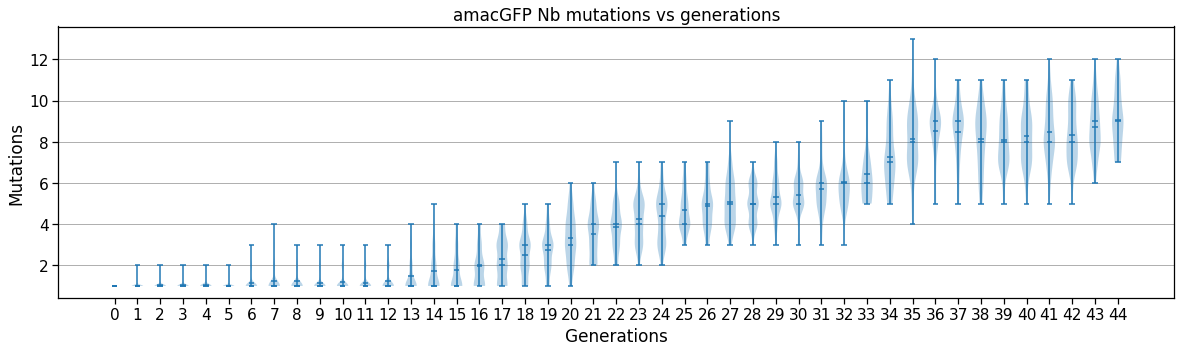

In [51]:

violins_per_line = len(genetic_log)
nb_subfigs =int(len(fitnesses_log)/violins_per_line)
fig, ax = plt.subplots(nb_subfigs,
                       1,
                       figsize=(20, 5*nb_subfigs))
if nb_subfigs==1:
    ax=[ax]
fig.patch.set_facecolor('w')

def chunks(lst, n):
    bits=[]
    for i in range(0, len(lst), n):
        bits.append(lst[i:i + n])
    return(bits) 


# -------------------------------
# get the number of mutations in each genotype of each generation, ignoring wt mutations
to_be_plotted = [[len([mut for mut in genotype.split(":") if mut!="" and mut[0]!=mut[-1]]) for genotype in list(genetic_log[g][genotype_col].values)] for g in sorted(genetic_log.keys())]
# -------------------------------

subsets = chunks(to_be_plotted,violins_per_line)
ticks = chunks(range(len(to_be_plotted)),violins_per_line)

for i in range(len(subsets)) :
    
    ax[i].violinplot(dataset=subsets[i],
                     positions=ticks[i],
                     showmeans=True,
                     showmedians=True)
    
    ax[i].yaxis.grid(True)
    ax[i].set_xlabel('Generations')
    ax[i].set_ylabel("Mutations")
    
    ax[i].set_xticks(ticks[i])

    ax[i].set_axisbelow(True)

plt.title(gene_name+" Nb mutations vs generations")
plt.show()

### Summary table


Note:
* native_to_pseudo_pos (dict)
* native_mut_to_pseudo (function)
* native_genotype_to_pseudo (function)

are defined in 01_Load_data.ipynb

In [52]:
# Save genotypes converted to pseudo-genotypes as well (could be useful)
random_pop["aa_genotype_pseudo"]=random_pop[genotype_col].apply(lambda x:native_genotype_to_pseudo(x))


In [53]:
# save run parameters 
random_pop["param_gene_name"]=gene_name
random_pop["param_nb_mutation_target"]=nb_mutation_target
random_pop["param_generations"]=generations
random_pop["param_non_extant_enrich"]=non_extant_enrich
random_pop["param_counter_selection"]=counter_selection
random_pop["param_mut_proba"]=mut_proba
random_pop["param_pop_size"]=pop_size
random_pop["param_ratio"]=ratio


In [54]:
# save genotype distance to wt
random_pop["distance"]=random_pop[genotype_col].apply(lambda x:len(x.split(":")))

In [55]:
# save run data

if record:    
    if non_extant_enrich:suffix="_non_extant_enrich"
    else:suffix=""
    random_pop.to_csv(join(geneticAlgo_output_folder,f"GeneticAlgo_run_{gene_name}_target{nb_mutation_target}muts_{str(datetime.now()).replace(':','-')}_last_generation{suffix}.csv"))